# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. Using this network, we will be generated new digits!

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

The following example is credited to [Sayak Paul](https://x.com/RisingSayak)

## Install the tensorflow docs packages

The first step is to install the following package.

```
pip install -q git+https://github.com/tensorflow/docs
```

## Import necessary packages

In [24]:
pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [25]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

## Define some constants

In [26]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [27]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## Calculate the dimsions needed

In [28]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Create the discriminator

In [29]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        # Create another 2D convolusion layer with 128 channels, 3x3 kernel, and 2x2 stride. Followed by leaky ReLU.
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

In [62]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 64)          │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,385 (314.00 KB)

 Trainable params: 80,385 (314.00 KB)

 Non-trainable params: 0 (0.00 B)

## Create the generator

In [30]:
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        # Add another 2D transpose layer with 128 kernels (4x4) and 2x2 stride, followed by leaky ReLU.
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [61]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 6762)                │         939,918 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 6762)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 138)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 128)         │         282,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 1)           │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,491,215 (5.69 MB)

 Trainable params: 1,491,215 (5.69 MB)

 Non-trainable params: 0 (0.00 B)

## Creates the GAN

In [31]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            # Implement the discriminator loss.
            real_preds = self.discriminator(real_image_and_labels)
            real_loss = self.loss_fn(ops.ones_like(real_preds), real_preds) # Label real although this is all training

            fake_preds = self.discriminator(fake_image_and_labels)
            fake_loss = self.loss_fn(ops.zeros_like(fake_preds), fake_preds) # Label fake

            d_loss = real_loss + fake_loss

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        if grads is None or all(g is None for g in grads):
          raise BaseException("No gradients provided for the discriminator. Fix the model or loss function properly.")

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.ones((batch_size, 1)) #ops.zeros((batch_size, 1)) # shouldn't this be 1 since these are false truths? Perhaps it is 'I' who is misled

        # Train the generator.
        with tf.GradientTape() as tape:
            # Implement the generator loss g_loss
            fake_images = self.generator(random_vector_labels)

            fake_images_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            fake_preds = self.discriminator(fake_images_and_labels)

            g_loss = self.loss_fn(misleading_labels, fake_preds)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)

        if grads is None or all(g is None for g in grads):
          raise BaseException("No gradients provided for the generator. Fix the model or loss function properly.")

        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Build a GAN and train it

In [32]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),)

gan.fit(dataset, epochs=20) # Fit sets default training=True

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - d_loss: 0.8464 - g_loss: 1.5123
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - d_loss: 1.0151 - g_loss: 1.2585
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - d_loss: 0.8072 - g_loss: 1.4667
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - d_loss: 0.4114 - g_loss: 2.3079
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - d_loss: 0.9039 - g_loss: 1.6628
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - d_loss: 1.2318 - g_loss: 1.0485
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - d_loss: 1.2881 - g_loss: 0.9387
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - d_loss: 1.3299 - g_loss: 0.8738
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - d_loss: 1.3630 - g_loss: 0.8066
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 1.3571 - g_loss: 0.7884
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - d_loss: 1.3711 - g_loss: 0.7637
Epoch 12

## Generat some images

In [59]:
trained_gen = gan.generator

num_interpolation = 9

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))

def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 5  # @param {type:"slider", min:0, max:9, step:1}
end_class = 3  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


## Display the fake images


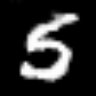

In [60]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")

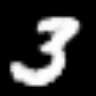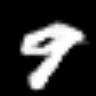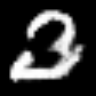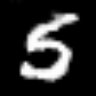

# Analysis

I Generated a bunch of numbers and found that the accuracy on 3 -> 8 and 2 -> 9 was sorely lacking. I found that 7 -> 2 was also lacking. I attached some of my "good" tests above.

Only issue I had was with the zeros or ones-like for the misleading set. I switched to ones-like (false positives, ie: telling the discriminator that these are real but they're not) and got meaningful output.

## GAN

A Gan is a pair of models, a Discrimiantor and Generator. Our Discriminator in this case is taking the split MNIST input, training on "real" numbers with labels, and then making predictions based on the test set. It then takes "fake" numbers with labels, and then makes predictions based on that test set. Then it takes the loss of each and computes the d_loss. The loss on the generator is computed with BCE and updated across the model.

The Generator on the other hand is taking a bunch of random vectors in the latent space, predicting some values on that, and misleadingly saying "hey these are all (whatever you think they are; label 1 for true)". Then feeding them back to the Discriminator, who is trying to verify. The loss on the generator is then computed with BCE and updated across the model.

As we train, the generator starts with much greater loss values first and the discriminator eventually catches up and passes it.

In the model output/generation we are interpolating two numbers and generating an output based on what we entered. The image shows the "generative" process that the model is going through as it starts from the starting class and ends in the ending class.

Some optimizations would be to tweak some hyperparams like LR, but also to explore densifying the discriminator or trying a different loss function, or perhaps starting the d_loss at a lower value with more epochs to see if it gets more discriminatory.

In [62]:
%%shell

jupyter nbconvert --to html /content/Lab08.ipynb